In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from flash_ansr import FlashANSR, get_path, FlashANSRTransformer, ExpressionSpace
from flash_ansr.expressions.utils import codify, num_to_constants

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [2]:
MODEL = 'v7.0'
CHECKPOINT = ''

In [3]:
trf = FlashANSRTransformer.load(get_path('models', 'ansr-models', MODEL, CHECKPOINT))[1].eval()
space = ExpressionSpace.from_config(get_path('models', 'ansr-models', MODEL, CHECKPOINT, 'expression_space.yaml'))

In [4]:
trf.embedding

Embedding(33, 512)

In [5]:
# Compute the pairwise similarities between the embeddings
def similarity(embeddings):
    return torch.mm(embeddings, embeddings.t()) / (embeddings.norm(dim=1) * embeddings.norm(dim=1).unsqueeze(1))

In [6]:
similarities = similarity(trf.embedding.weight)
print(similarities.shape)

torch.Size([33, 33])


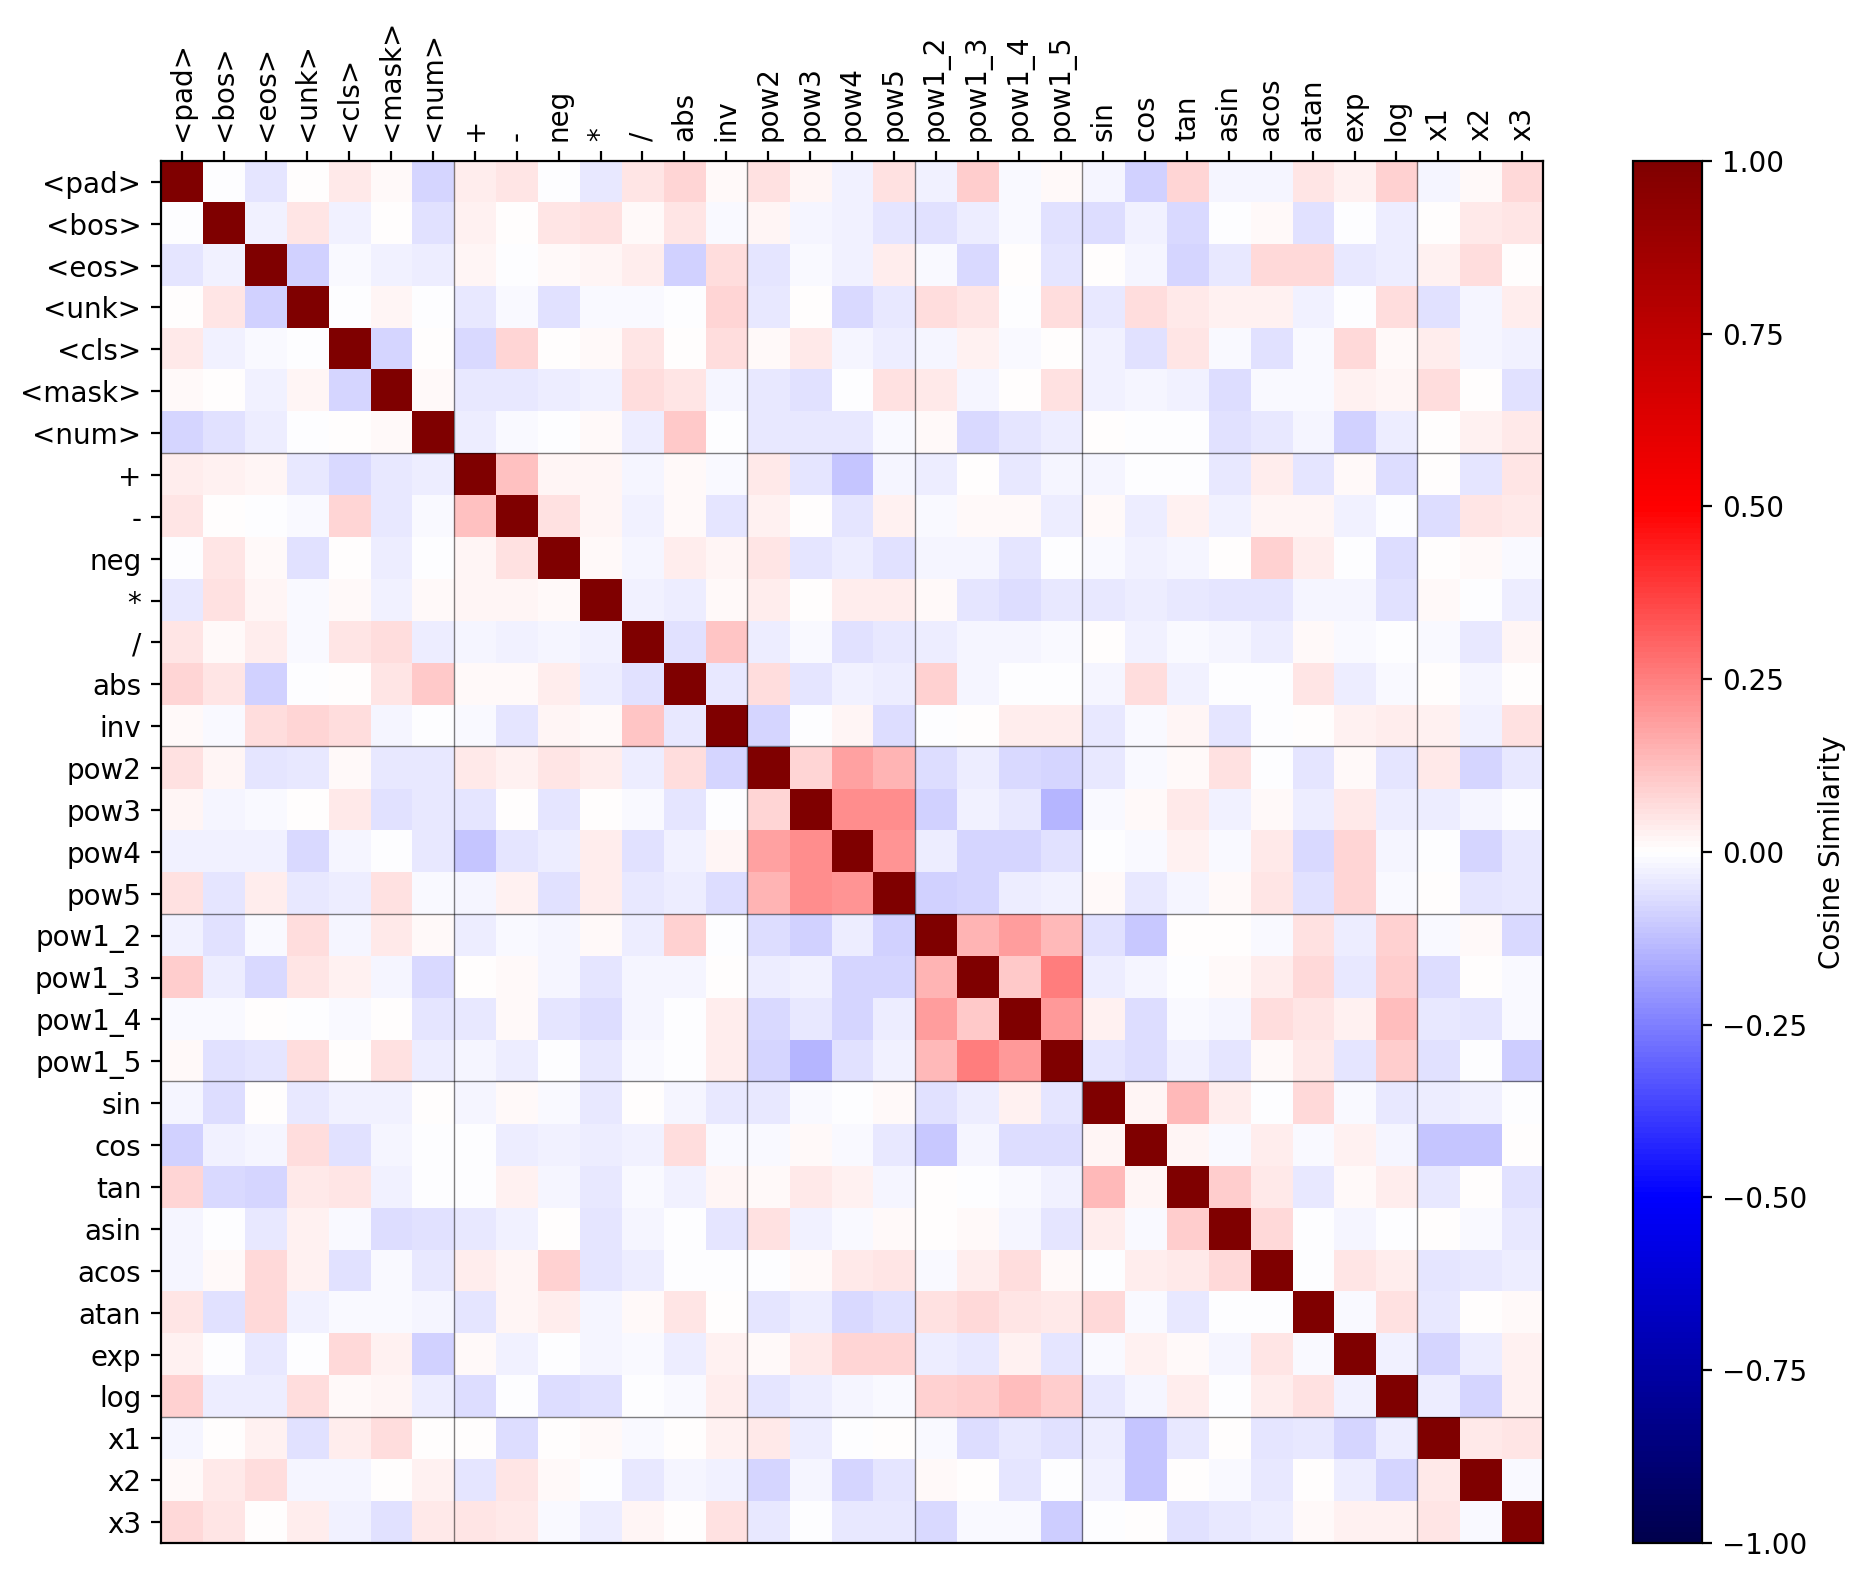

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=200)

im = ax.matshow(similarities.cpu().detach().numpy(), cmap='seismic', vmin=-1, vmax=1, rasterized=True)

ax.set_xticks(np.arange(len(space.tokenizer)))
ax.set_yticks(np.arange(len(space.tokenizer)))

ax.set_xticklabels(space.tokenizer.vocab, rotation=90)
ax.set_yticklabels(space.tokenizer.vocab)

# Move the xticks to the top
ax.xaxis.set_ticks_position('top')

# Add a colorbar the same height as the image
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Cosine Similarity')

for i in [6, 13, 17, 21, 29]:
    ax.axhline(i + 0.5 - 0.02, color='k', lw=0.5, alpha=0.5)
    ax.axvline(i + 0.5, color='k', lw=0.5, alpha=0.5)

fig.tight_layout()

plt.savefig(get_path('results', 'operator_embeddings', create=True, filename='operator_embeddings.svg'))